
Кількість рядків у вибраних альбомах:
album
1989 (Deluxe)    1211
folklore          807
Name: count, dtype: int64


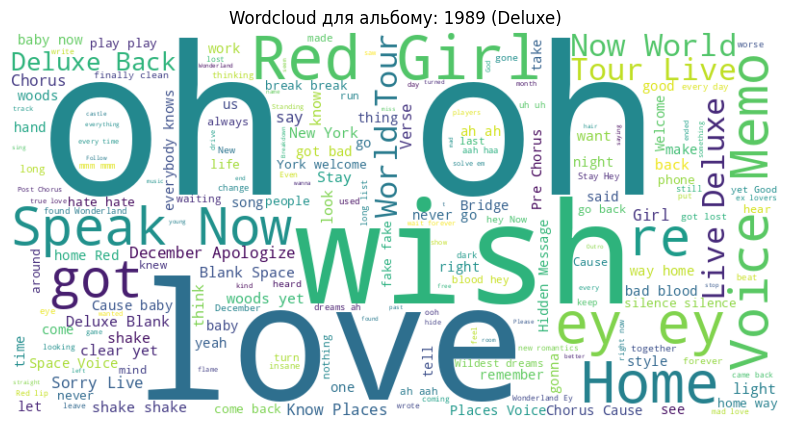

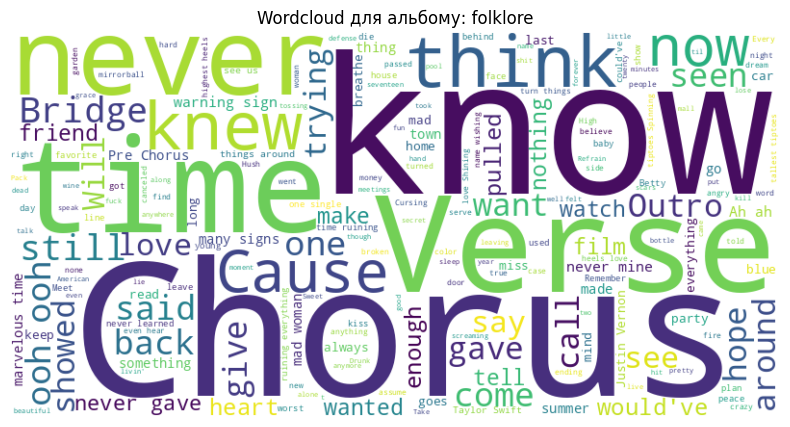


Розмір навчальної вибірки: (1614, 1000)
Розмір тестової вибірки: (404, 1000)

=== Класифікаційний звіт ===
               precision    recall  f1-score   support

1989 (Deluxe)       0.78      0.80      0.79       242
     folklore       0.68      0.65      0.67       162

     accuracy                           0.74       404
    macro avg       0.73      0.73      0.73       404
 weighted avg       0.74      0.74      0.74       404



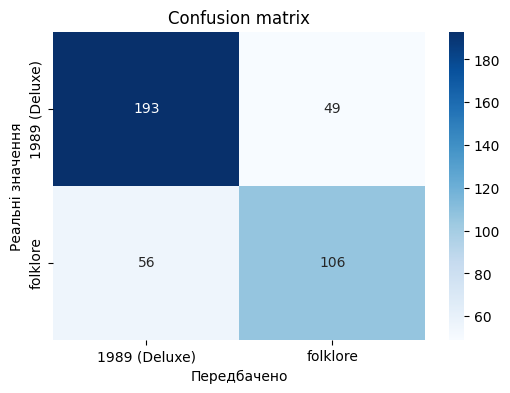

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# === Завантаження даних (TSV!) ===
df = pd.read_csv("/content/final_taylor_swift_lyrics.tsv",
                 sep="\t",
                 encoding="utf-8")

# === Попередня обробка ===
df = df.dropna(subset=["lyric", "album"])
df["lyric"] = df["lyric"].astype(str)

# === Вибір 2 альбомів для класифікації ===
albums_to_use = ["1989 (Deluxe)", "folklore"]
df = df[df["album"].isin(albums_to_use)]

print("\nКількість рядків у вибраних альбомах:")
print(df['album'].value_counts())

# === WordCloud для кожного альбому ===
def visualize(album_name):
    album_data = df[df["album"] == album_name]
    album_text = " ".join(album_data["lyric"].dropna().astype(str))

    if len(album_text.strip()) == 0:
        print(f"Пропуск альбому '{album_name}' — немає текстів пісень.")
        return

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(album_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud для альбому: {album_name}")
    plt.show()

for alb in albums_to_use:
    visualize(alb)

# === Підготовка даних для моделі ===
X = df["lyric"]
y = df["album"]

# TF-IDF з n-grams (1-2)
vectorizer = TfidfVectorizer(stop_words="english",
                             max_features=1000,
                             ngram_range=(1,2))

X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)

print("\nРозмір навчальної вибірки:", X_train.shape)
print("Розмір тестової вибірки:", X_test.shape)

# === Навчання MultinomialNB ===
model = MultinomialNB(alpha=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# === Оцінка якості ===
print("\n=== Класифікаційний звіт ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel("Передбачено")
plt.ylabel("Реальні значення")
plt.title("Confusion matrix")
plt.show()
